In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
tf.random.set_seed(0)
# np.random.seed(123)
import matplotlib.pyplot as plt
%matplotlib inline

### 1. Load data
- set the load data row number
- set colunms names
- remove useless colunms

In [3]:
row_num = 40000
test_num= 5500
n_time_steps = 30
n_features = 9
n_epoch = 200
batch_size=256


In [4]:
from ppl_util import DataUtil

In [5]:
path_list = ["data/DoS_dataset.csv","data/Fuzzy_dataset.csv","data/gear_dataset.csv",'data/RPM_dataset.csv',"data/normal_run_data.txt"]
data_util = DataUtil(n_row=row_num, path_list=path_list, n_time_step=n_time_steps, n_features=n_features)

In [6]:
dataset = data_util.read_files(is_shuffle=True)
dataset.head()

/home/laha/anaconda3/envs/tf_ppl/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/home/laha/anaconda3/envs/tf_ppl/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/home/laha/anaconda3/envs/tf_ppl/lib/python3.8/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

,features,label
4039,"[[0.46960667461263406, 0.27058823529411763, 0....",3
3579,"[[0.6466030989272944, 0.00392156862745098, 0.3...",2
6471,"[[0.8027413587604291, 0.8470588235294118, 0.0,...",4
4229,"[[0.18951132300357568, 0.0, 0.0, 0.0, 0.0, 0.1...",3
4544,"[[0.36114421930870083, 0.09803921568627451, 0....",3


In [7]:
features, label = data_util.get_train_data()

In [8]:
features.shape

(6474, 30, 9)

In [9]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential

In [10]:
from tensorflow.keras.layers import Input,Conv1D,Dropout,MaxPooling1D,Flatten,Dense

In [11]:
divergence_fn = lambda q,p,_: tfd.kl_divergence(q,p)/features.shape[0]
def kl_approx(q, p, q_tensor):
    return tf.reduce_mean(q.log_prob(q_tensor) - p.log_prob(q_tensor))

In [12]:
model = Sequential([
    tfpl.Convolution1DReparameterization(
    input_shape=(n_time_steps,n_features),filters=16, kernel_size=3,activation='relu',
    kernel_prior_fn = tfpl.default_multivariate_normal_fn,
    kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
    kernel_divergence_fn = divergence_fn,
    bias_prior_fn = tfpl.default_multivariate_normal_fn,
    bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
    bias_divergence_fn =  divergence_fn   
    ),
    tfpl.Convolution1DReparameterization(
    filters=16, kernel_size=3,activation='relu',
    kernel_prior_fn = tfpl.default_multivariate_normal_fn,
    kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
    kernel_divergence_fn = divergence_fn,
    bias_prior_fn = tfpl.default_multivariate_normal_fn,
    bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
    bias_divergence_fn =  divergence_fn   
    ),
#     tfpl.Convolution1DReparameterization(
#     filters=16, kernel_size=3,activation='relu',
#     kernel_prior_fn = tfpl.default_multivariate_normal_fn,
#     kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
#     kernel_divergence_fn = divergence_fn,
#     bias_prior_fn = tfpl.default_multivariate_normal_fn,
#     bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
#     bias_divergence_fn =  divergence_fn   
#     ),
    MaxPooling1D(16),
    Flatten(),
    tfpl.DenseReparameterization(
        units = tfpl.OneHotCategorical.params_size(5),activation=None,
        kernel_prior_fn = tfpl.default_multivariate_normal_fn,
        kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
        kernel_divergence_fn = divergence_fn,
        bias_prior_fn = tfpl.default_multivariate_normal_fn,
        bias_posterior_fn = tfpl.default_mean_field_normal_fn(is_singular=False),
        bias_divergence_fn =  divergence_fn   
    ),
    tfpl.OneHotCategorical(5)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_reparameterization (C (None, 28, 16)            896       
_________________________________________________________________
conv1d_reparameterization_1  (None, 26, 16)            1568      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 16)             0         
_________________________________________________________________
flatten (Flatten)            (None, 16)                0         
_________________________________________________________________
dense_reparameterization (De (None, 5)                 170       
_________________________________________________________________
one_hot_categorical (OneHotC multiple                  0         
Total params: 2,634
Trainable params: 2,634
Non-trainable params: 0
______________________________________________________

/home/laha/anaconda3/envs/tf_ppl/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


In [13]:
def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll,
              optimizer='adam',
              metrics=['categorical_accuracy'],
              experimental_run_tf_function=False)

In [14]:
history = model.fit(features[:test_num], label[:test_num], epochs=n_epoch, batch_size=batch_size,
                    validation_data=(features[test_num:], label[test_num:]))

Epoch 1/200
22/22 [==============================] - 2s 20ms/step - loss: 2.1279 - categorical_accuracy: 0.2018 - val_loss: 2.1212 - val_categorical_accuracy: 0.1961
Epoch 2/200
22/22 [==============================] - 0s 4ms/step - loss: 2.1101 - categorical_accuracy: 0.2013 - val_loss: 2.1066 - val_categorical_accuracy: 0.2043
Epoch 3/200
22/22 [==============================] - 0s 4ms/step - loss: 2.0848 - categorical_accuracy: 0.2164 - val_loss: 2.0834 - val_categorical_accuracy: 0.2279
Epoch 4/200
22/22 [==============================] - 0s 4ms/step - loss: 2.0560 - categorical_accuracy: 0.2149 - val_loss: 2.0348 - val_categorical_accuracy: 0.2033
Epoch 5/200
22/22 [==============================] - 0s 4ms/step - loss: 2.0085 - categorical_accuracy: 0.2362 - val_loss: 2.0028 - val_categorical_accuracy: 0.2598
Epoch 6/200
22/22 [==============================] - 0s 4ms/step - loss: 1.9572 - categorical_accuracy: 0.2467 - val_loss: 1.9382 - val_categorical_accuracy: 0.2485
Epoch 7/2

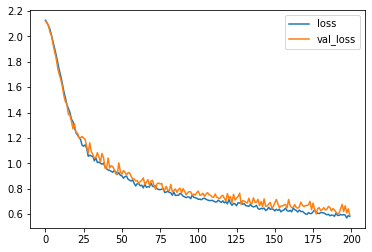

In [15]:
x = list(range(n_epoch))
plt.plot(x, history.history['loss'],label="loss")
plt.plot(x, history.history['val_loss'],label="val_loss")
plt.legend();

In [16]:
np.argmax(label[1])

2

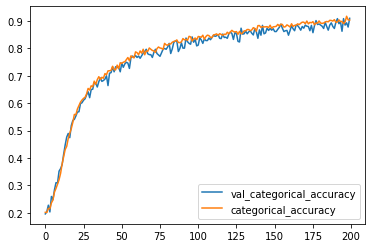

In [17]:
plt.plot(x, history.history['val_categorical_accuracy'],label="val_categorical_accuracy")
plt.plot(x, history.history['categorical_accuracy'],label="categorical_accuracy")
plt.legend();

In [18]:
x_test = features[test_num:]
y_test = dataset[test_num:].label.to_list()

In [19]:
x_test.shape,len(y_test)

((974, 30, 9), 974)

In [20]:
import seaborn as sns
sns.set_theme(style="white")

In [21]:
label_list = ['DoS', 'Fuzzy', 'RPM', 'gear',  'Normal']

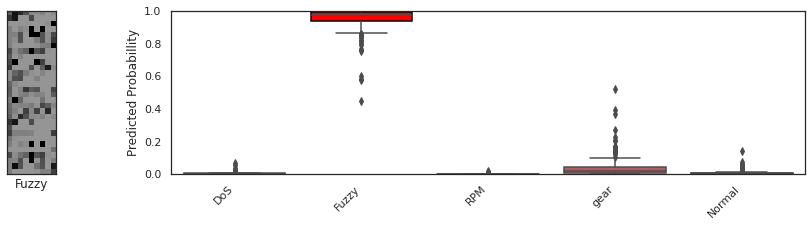

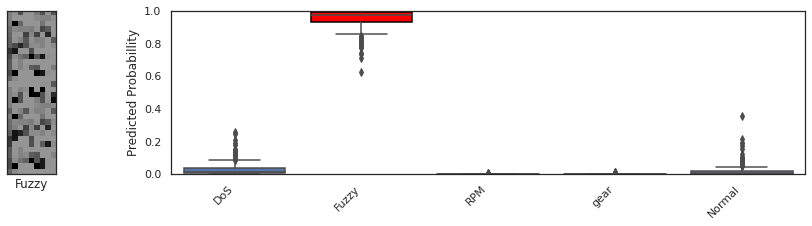

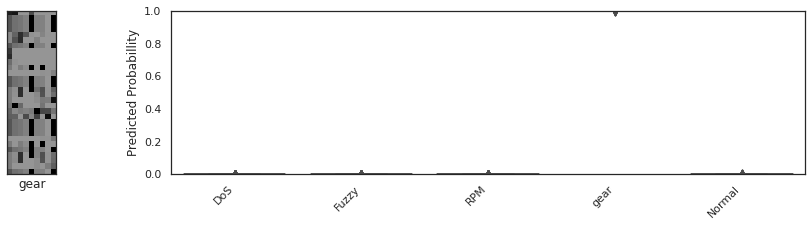

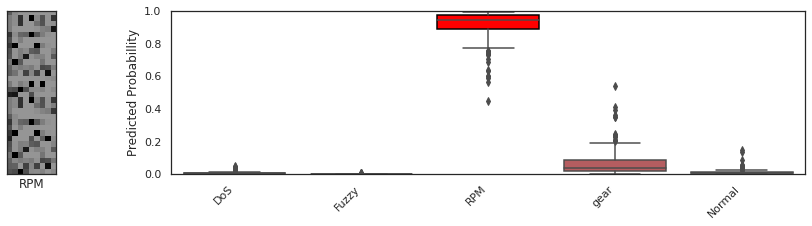

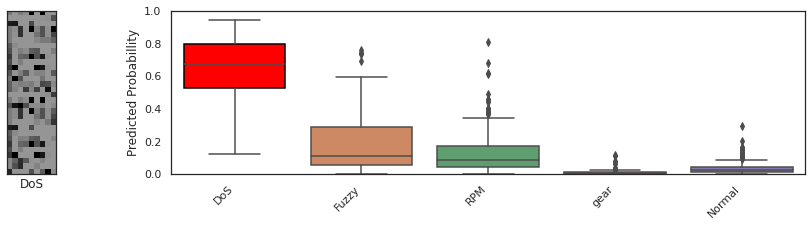

In [40]:
def plot_pred_dist(act_num,n_samples=200):
    label = data_util.label_to_activity[y_test[act_num]]
    fig, axes = plt.subplots(1,2,figsize=(15,3),gridspec_kw={'width_ratios': [1, 5]})
    axes[0].imshow(x_test[act_num], cmap='Greys', vmin=-1, vmax=1)
#     ax.axis('off')
    axes[0].axes.yaxis.set_ticks([])
    axes[0].axes.xaxis.set_ticks([])
    axes[0].set_xlabel(label)
#     plt.show()

  
    pred_prob = np.empty(shape=(n_samples, 5))
    for i in range(n_samples):
        pred_prob[i] = model(x_test[act_num][np.newaxis, ...]).mean().numpy()[0]
#     plt.figure(figsize=(10,3))
    axes[1] = sns.boxplot(data=pred_prob)
    
    mybox = axes[1].artists[y_test[act_num]]

    # Change the appearance of that box
    mybox.set_facecolor('red')
    mybox.set_edgecolor('black')


    axes[1].set_xticks(np.arange(5))
    axes[1].set_xticklabels(label_list,rotation=45, horizontalalignment='right')
    axes[1].set_ylim([0, 1])
    axes[1].set_ylabel('Predicted Probabillity')
    plt.show();
for i in [1,100,250,12,50]:
    plot_pred_dist(i)

In [23]:
def analyse_model_predictions(action_num):
    
    # Show the accelerometer data
    print('------------------------------')
    print('Attack data:')
    fig, ax = plt.subplots(figsize=(10, 1))
    ax.imshow(x_test[action_num].T, cmap='Greys', vmin=-1, vmax=1)
    ax.axis('off')
    plt.show()

    # Print the true activity
    print('------------------------------')
    print('Attack Event:', data_util.label_to_activity[y_test[action_num]])
    print('')

    # Print the probabilities the model assigns
    print('------------------------------')
    print('Model estimated probabilities:')
    # Create ensemble of predicted probabilities
    predicted_probabilities = np.empty(shape=(200, 5))
    for i in range(200):
        predicted_probabilities[i] = model(x_test[action_num][np.newaxis, ...]).mean().numpy()[0]
    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(5)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(5)])
    # Make the plots
    fig, ax = plt.subplots(figsize=(9, 3))
    bar = ax.bar(np.arange(5), pct_97p5, color='red')

    
    bar[y_test[action_num]].set_color('blue')
    bar = ax.bar(np.arange(5), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax.set_xticks(np.arange(5))
    ax.set_xticklabels(label_list,rotation=45, horizontalalignment='right')
    

    ax.set_ylim([0, 1])
    ax.set_ylabel('Probability')
    plt.show()

------------------------------
Attack data:


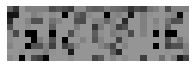

------------------------------
Attack Event: Fuzzy

------------------------------
Model estimated probabilities:


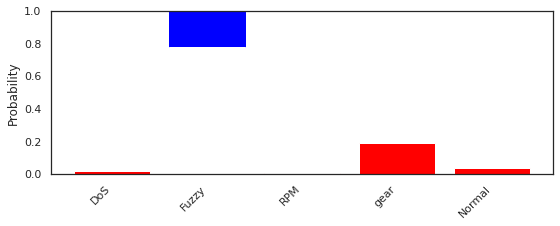

------------------------------
Attack data:


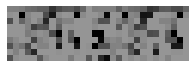

------------------------------
Attack Event: Fuzzy

------------------------------
Model estimated probabilities:


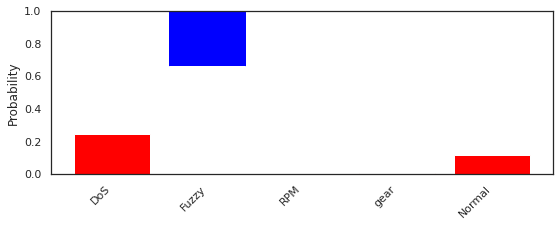

------------------------------
Attack data:


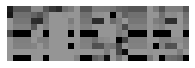

------------------------------
Attack Event: gear

------------------------------
Model estimated probabilities:


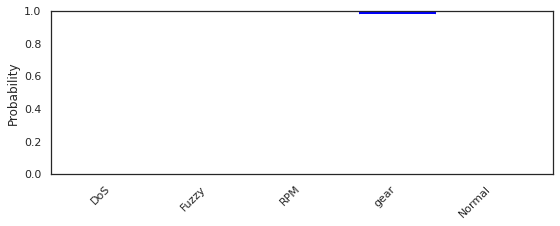

------------------------------
Attack data:


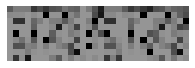

------------------------------
Attack Event: RPM

------------------------------
Model estimated probabilities:


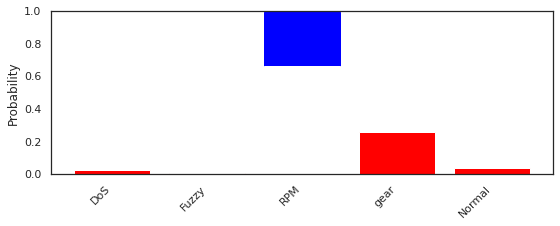

------------------------------
Attack data:


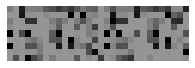

------------------------------
Attack Event: DoS

------------------------------
Model estimated probabilities:


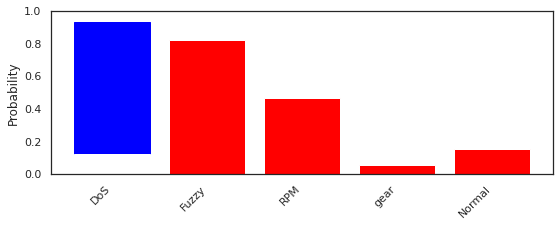

In [24]:
for i in [1,100,250,12,50]:
    analyse_model_predictions(i)

In [25]:
x_test.shape

(974, 30, 9)

In [26]:
def plot_mnorm_dist(act_num,n_samples=1000):
    pred_prob = model(x_test[act_num][np.newaxis, ...])
    cov = pred_prob.covariance().numpy()[0]
    sigma = cov.diagonal()
    mu = pred_prob.mean()[0]
    dict_data = {}
    for i in range(5):
        dist = np.random.normal(mu[i], sigma[i], n_samples)
        dict_data[data_util.label_to_activity[i]] = dist
    df = pd.DataFrame(dict_data)
    g = sns.displot(df,kind='kde', fill=True)
#     g.set(xlim=(0,None));
    plt.xlabel('probability, Test Index={} True Label:{}'.format(act_num,data_util.label_to_activity[y_test[act_num]]))
#     print("----------Test sample ndex----------",act_num)


In [62]:
# test_indx = np.random.choice(range(x_test.shape[0]), 20, replace=False).tolist()
# for i in test_indx:
#     plot_mnorm_dist(i)

In [63]:
def plot_pred_dist(act_num,n_samples=100):
  
    pred_prob = np.empty(shape=(n_samples, 5))
    for i in range(n_samples):
        pred_prob[i] = model(x_test[act_num][np.newaxis, ...]).mean().numpy()[0]
    df =  pd.DataFrame(data=pred_prob)
    df.columns = label_list
    g = sns.displot(df,kind='kde', fill=True)
#     g.set(xlim=(0,None))
    plt.xlabel('probability, True Label:{}'.format(data_util.label_to_activity[y_test[act_num]]))

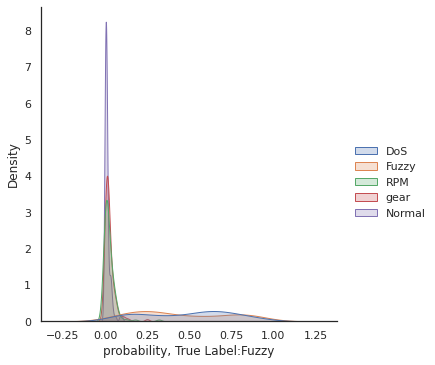

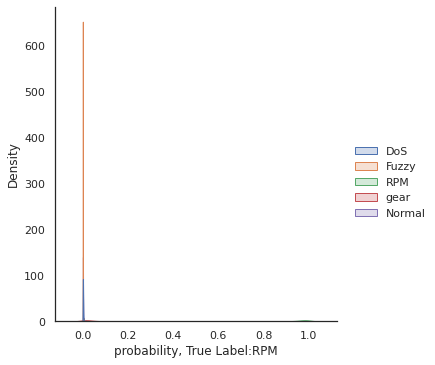

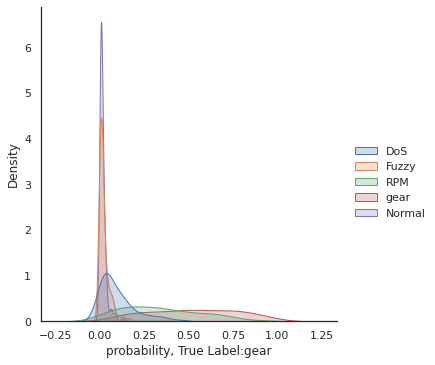

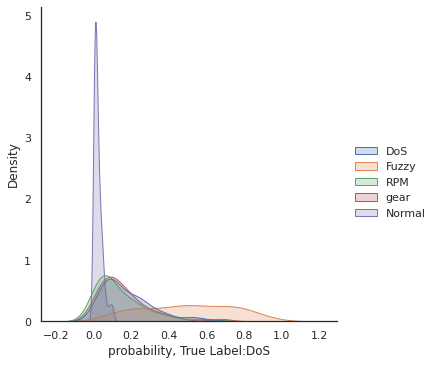

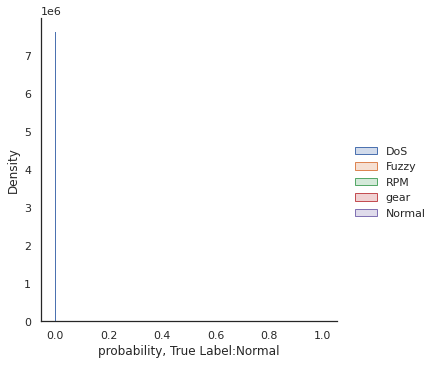

In [64]:
for i in [255,99,536,938,767]:
    plot_pred_dist(act_num=i)

In [65]:
def get_pred_df(n_test_samples = x_test.shape[0],n_sample=1):
  
    pred_prob = np.empty(shape=(n_test_samples*n_sample, 5))
    indx = 0
    for i in range(n_test_samples):
        for j in range(n_sample):
            pred_prob[indx] = model(x_test[i][np.newaxis, ...]).mean().numpy()[0]
            indx += 1
    df =  pd.DataFrame(data=pred_prob)
    df.columns = label_list
    return df
df = get_pred_df(100)
df.head()

,DoS,Fuzzy,RPM,gear,Normal
0,4.078695e-01,2.739348e-03,5.588875e-01,0.012458,0.018046
1,8.523979e-03,9.861118e-01,7.507897e-04,0.003271,0.001343
2,4.075129e-08,4.560875e-05,1.077714e-07,0.001455,0.998499
3,5.799741e-01,1.719571e-02,3.943961e-01,0.007997,0.000437
4,1.825391e-07,2.377460e-07,4.191997e-03,0.995700,0.000108


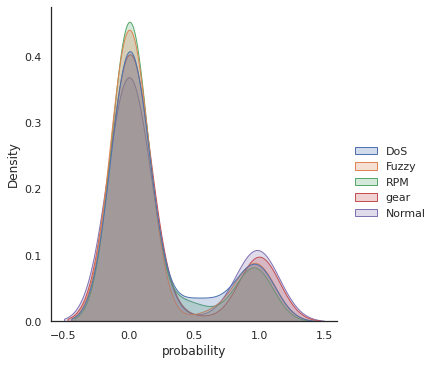

In [66]:
g = sns.displot(df,kind='kde', fill=True)
plt.xlabel('probability');

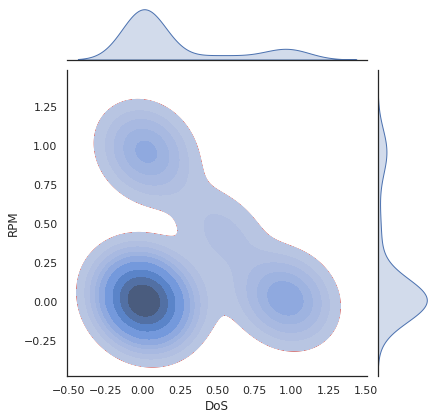

In [67]:
g = sns.jointplot(data=df, x="DoS", y="RPM",kind='kde', fill=True)
g.plot_joint(sns.kdeplot, color="r", zorder=0, levels=6);

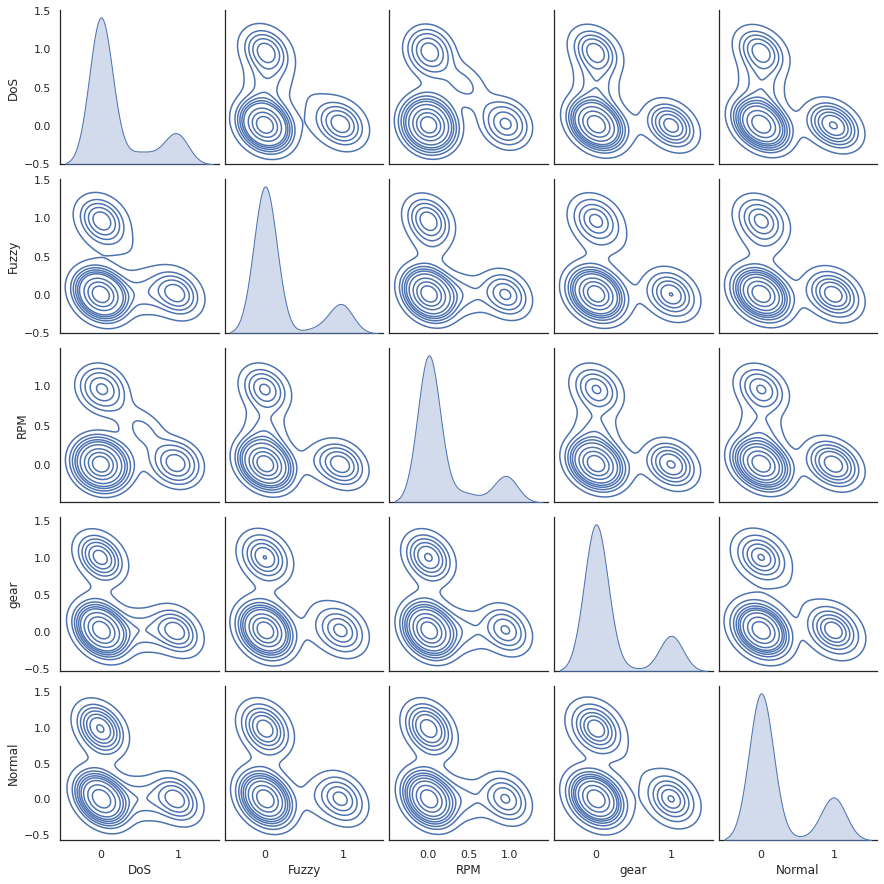

In [68]:
sns.pairplot(df, kind="kde");

In [69]:
pred = model(x_test[2][np.newaxis, ...])

In [70]:
sigma = pred.stddev()[0]

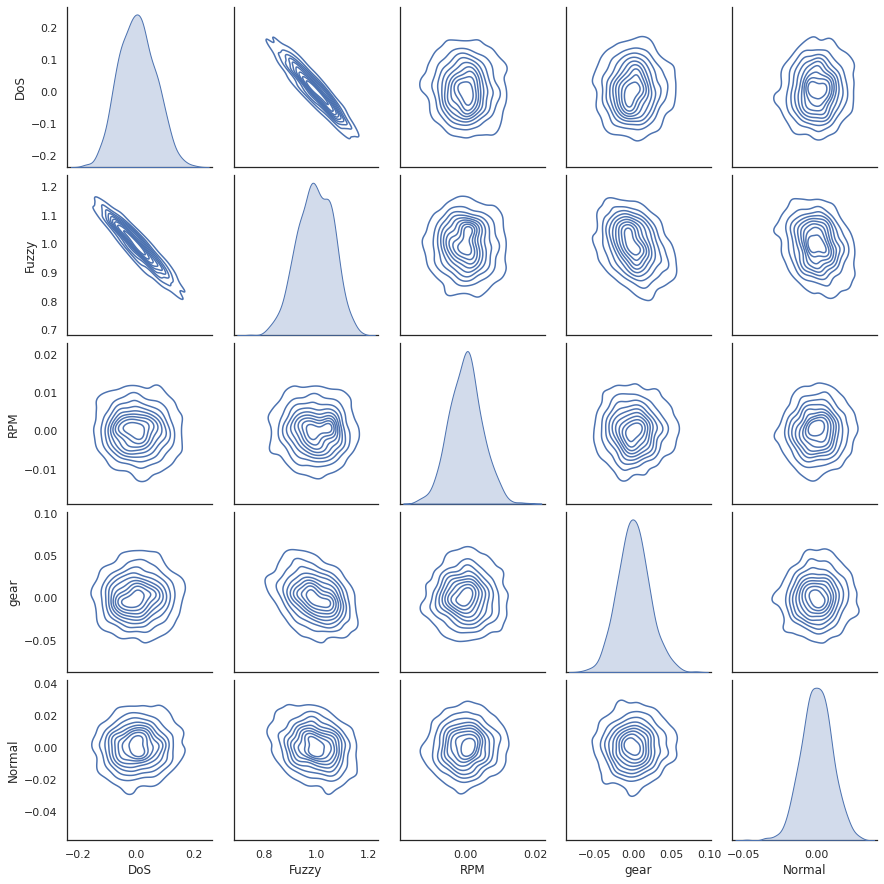

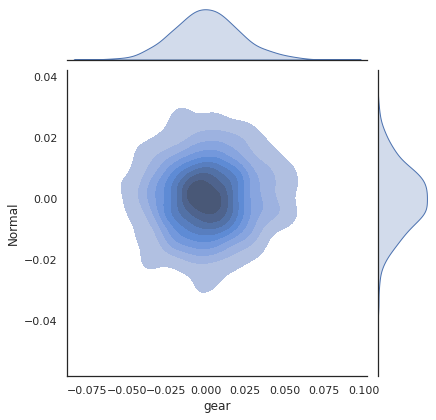

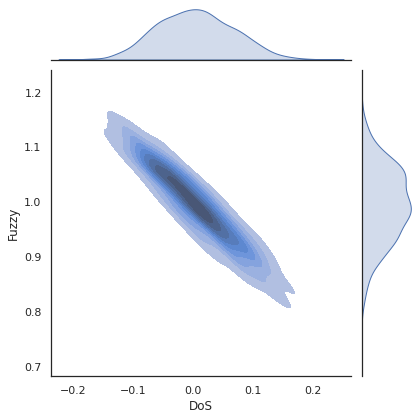

In [71]:
def plot_correlation(act_num):
    pred = model(x_test[act_num][np.newaxis, ...])
    mu = pred.mean()[0]
    cov = pred.covariance()[0]
    arr = np.random.multivariate_normal(mu, cov, 1000)
    df =  pd.DataFrame(data=arr)
    df.columns = label_list
    sns.pairplot(df, kind="kde")
    sns.jointplot(data=df, x="gear", y="Normal",kind='kde', fill=True)
    sns.jointplot(data=df, x="DoS", y="Fuzzy",kind='kde', fill=True)
plot_correlation(5)

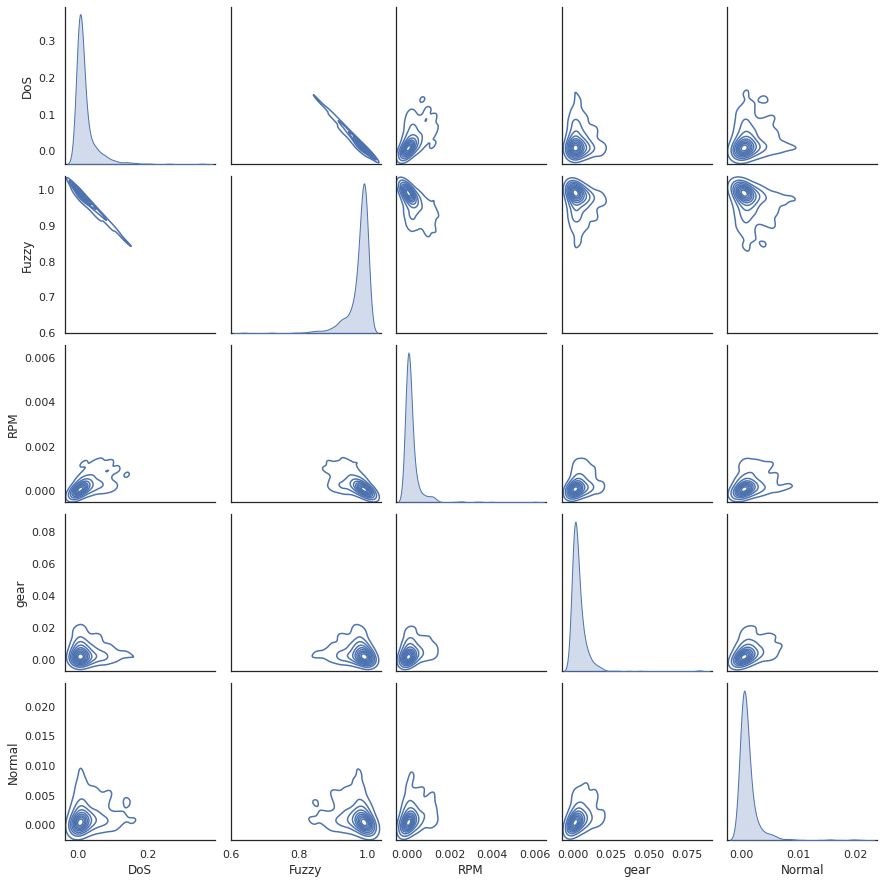

In [72]:
def plot_correlation(act_num,n_samples=500):
    pred_prob = np.empty(shape=(n_samples, 5))
    for i in range(n_samples):
        pred_prob[i] = model(x_test[act_num][np.newaxis, ...]).mean().numpy()[0]
    df =  pd.DataFrame(data=pred_prob)
    df.columns = label_list
    sns.pairplot(df, kind="kde")
#     sns.jointplot(data=df, x="gear", y="Normal",kind='kde', fill=True)
plot_correlation(5)